# Part I: Cleaning, EDA, and modeling for Kaggle Competition
### Prediction
Outputs supply clean data and guide the approach to the presentation [Technical Report Part II](http://localhost:8888/notebooks/Presentation%20Notebook%20v2.ipynb), but the presentation problem statement is autonomous.

## Merging Train and Test for cleaning
The steps for cleaning were determined using only the training data, so there was no risk of data leakage influencing decision-making.  Here I knit the train and test sets together in order to clean them simultaneously instead of side by side.  Care is taken to keep train and test data identified and separated from each other in this aggregate cleaning.

In [1]:
import numpy as np
import pandas as pd
import scipy as stats
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import os

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

## Citations
Source 1: 'Intermediate Data Cleaning' by Kevin Crystal, GA-DSI alumn
- https://medium.com/@kevin.a.crystal/intermediate-data-cleaning-195e1af3ccf9
- Mostly used for conceptual approach to cleaning.  Noted in code notes if actual code used.


Source 2: 'Comprehensive data exploration with Python' by Pedro Marcelino
- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
- ripped code to print df of nulls and what % of the column those nulls represent


Source 3: 'A study on Regression applied to the Ames dataset' by Julien Cohen Solal
- https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

Source 4: 'Regularized Linear Models' by Alexandru Papiu
- https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

Source 5: 'Stacked Regressions: Top 4% on Leaderboard' by Serigne
- https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

Source 6: 'How to not fail this project' by Gwen Rathgerber
- process for creating dummy model
- idea for stretching the scale of ordinal variables
- some code chunks from the 'reusable-graphing-fx' document she disseminated

In [2]:
training = pd.read_csv('./datasets/train.csv')
testing = pd.read_csv('./datasets/test.csv')

In [3]:
#make folder for kaggle submission csvs
directory = 'kaggle_submissions_all'
if not os.path.isdir(directory):
    os.makedirs(directory)
    print("created folder: ", directory)
else:
    print(directory, "already exists")

kaggle_submissions_all already exists


In [4]:
print(training.shape, testing.shape)

(2051, 81) (878, 80)


In [5]:
training.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [6]:
#training.info()

In [7]:
#are df formats parallel for concatenating?
training_compare = training.drop(columns='SalePrice')
print(f'Starting with same columns?: {training_compare.columns.equals(testing.columns)}')
print(f'Columns same datatype?: {training_compare.dtypes.equals(testing.dtypes)}')  
#FALSE: at first glance, many ints as floats, which is fine
#confirm all 'objects' are same
train_types=training_compare.select_dtypes(include = 'object').columns
test_types=testing.select_dtypes(include = 'object').columns
print(f"'Object' columns same in each df?: {train_types.equals(test_types)}")

Starting with same columns?: True
Columns same datatype?: False
'Object' columns same in each df?: True


In [8]:
#nulls and what % of factor, code from Source 2
nulls= training.isnull().sum().sort_values(ascending=False)
perc= (training.isnull().sum()/training.isnull().count()).sort_values(ascending=False)
missing_train= pd.concat([nulls, perc],axis=1, keys=['# nulls', '% null'])
missing_train.head(27)

,# nulls,% null
Pool QC,2042,0.995612
Misc Feature,1986,0.968308
Alley,1911,0.931741
Fence,1651,0.804973
Fireplace Qu,1000,0.487567
Lot Frontage,330,0.160897
Garage Finish,114,0.055583
Garage Cond,114,0.055583
Garage Qual,114,0.055583
Garage Yr Blt,114,0.055583


# Pre-pre processing
A. snakecase that nonsense

B. Per the 'Special Notes' in the data dictionary, there are true outliers in the data that are evident upon graphing Saleprice and 'Gr Liv Area'.  The provider of the dataset recommends removing any houses with more than 4000 sqft from the data.  Perform this filter before merging with testing data.

C. Note in the above table that over 90% of the Pool QC, Misc Features, and Alley columns are null / empty.  This likely indicates no pool, misc feature, or alley, but either way these columns are not particularly informative.  Consider dropping in future.

In [9]:
#snakecase columns
training.columns = training.columns.str.lower().str.replace(" ","_")
testing.columns = testing.columns.str.lower().str.replace(" ","_")

In [10]:
#ala Gwen
def convert_snake_case(label, capitalize_first=True, capitalize_all=False):
    if capitalize_all:
        return ' '.join([word.capitalize() for word in label.split('_')])
    elif capitalize_first:
        return ' '.join([word.capitalize() if i == 0 else word for i, word in enumerate(label.split('_'))])
    else:
        return ' '.join([word for word in label.split('_')])

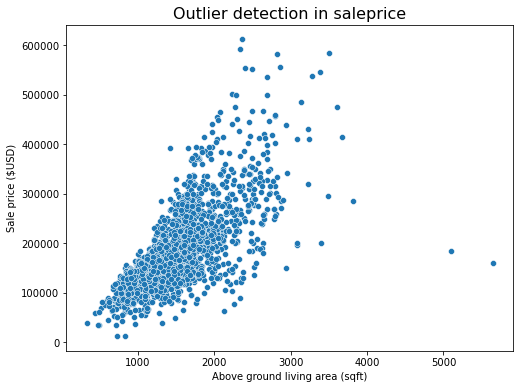

In [11]:
#look at those weirdos out there on the right
plt.figure(figsize=(8,6))
sns.scatterplot(x='gr_liv_area',y='saleprice',data=training);
plt.xlabel('Above ground living area (sqft)')
plt.ylabel('Sale price ($USD)')
plt.title('Outlier detection in saleprice', size=16);

In [12]:
#remove outliers by implementing recommended 4000sqft threshold
training = training[training['gr_liv_area']<4000]

# Pre-processing
## Merge train and test for synchronized cleaning
Separate saleprice (y_train) so train and test are the same shape.

In [13]:
#add identifier
training['is_train'] = 1
testing['is_train'] = 0

In [14]:
training.head(2)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,is_train
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,130500,1
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,220000,1


In [15]:
testing.head(2)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,is_train
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2006,WD,0
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,8,2006,WD,0


In [16]:
#merge all but saleprice
allofit = pd.concat((training.drop(columns='saleprice'), testing))

In [17]:
#allofit.head()

### False Nulls
According to the data dictionary, 'NA' can be used to indicate that a particular property attribute does not exist, amidst an otherwise ordinal list of ranking that attribute.  For instance, 'Rating of basement finished area' is on a scale of Unfinished up to Good Living Quarters, with NA indicating that there is no basement.  In this scenario, NA can = 0, Unfinished = 1, and Good Living Quarters = max.

NA is defined as its own level of ordinal rank (0) in the case of 12 variables.  Many of these share the same 6-level scale (NA, Po, Fa, TA, Gd, Ex).  They also share this scale with other ordinal variables in the dataset that do not contain (or define) NA.  I will convert all of these to a numeric scale together, with Na=0 to Ex=5.  

The Pool variable has all of these levels except for 'Po'; I will still include it in this same scale and just record 0 entries at (Po:1).  Apparently in Ames, any pool is already considered 'Fair', but as a water sport athlete I can tell you there are DEFINITELY 'Poor' pools and Ames county is ignoring a valuable metric.

---
### Not so false nulls


Other vars in the data dictionary were NOT stipulated to have meaningful NaNs.  I initially ran them through the same function to convert since there WERE no nulls, so it didn't matter that they were getting replaced with 0.  However, if the TEST data has nulls there, then I'm potentially messing with distribution.  For these vars (lot shape, utilities, land slope, electrical, functional), replace (hypothetical) nulls with the median of the training data.

In [18]:
#cols needing transform from (ordinal) object to numeric
nans_to_zeros = ['bsmt_qual','bsmt_cond', 'fireplace_qu','garage_qual', 'garage_cond',
                 'kitchen_qual', 'exter_qual','exter_cond','heating_qc','garage_finish', 
                 'bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2', 'pool_qc', 'fence']

nans_to_median = ['lot_shape','utilities','land_slope', 'electrical','functional']

In [19]:
to_num_masterdict={'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, #nans_to_zeros cols.
'Unf':1, 'RFn':2, 'Fin':3, #garage_finish
'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4, #fence
'No':1, 'Mn':2, 'Av':3, 'Gd':4,#bsmt_exposure
'Unf':1, 'LwQ':2,'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6, #bsmtfin_type_1 and 2
'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4, #lot_shape
'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4, #utilities
'Sev':1, 'Mod':2, 'Gtl':3, #land_slope
'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7, #functional
'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5} #electrical

In [20]:
#conversion function
def to_nums_fillna0(df, targetcols):
    for i in targetcols:
        df[i] = df[i].map(to_num_masterdict)
        df[i] = df[i].fillna(0) #no need inplace=T because assigning with =
        #print(df[targetcols].value_counts()) #this line to check work, from source1

In [21]:
to_nums_fillna0(allofit, nans_to_zeros)

In [22]:
def to_nums_fillna_median(df, targetcols):
    for i in targetcols:
        df[i] = df[i].map(to_num_masterdict)
        df[i] = df[i].fillna(allofit.loc[allofit['is_train']==1][i].median())

In [23]:
to_nums_fillna_median(allofit, nans_to_median)

In [24]:
#allofit[nans_to_zeros].dtypes  #check now numeric - yes

In [25]:
#allofit[nans_to_median].dtypes  #check now numeric - yes
#allofit[nans_to_median].isnull().sum() #no NaNs

In [26]:
#allofit.loc[allofit['is_train']==1].isnull().sum().sort_values(ascending=False).head(17)

## Nominal variables
Nominal variables with a NA definition, according to the data dictionary, are:  
- Alley (Grvl, Pave, NA)
- Garage Type (2Types, Attchd, Basment, BuiltIn, CarPort, Detchd, NA)
- Misc Feature (Elev, Gar2, Othr, Shed, TenC, NA)
- Masonry Veneer Type - not defined as such, but NaNs assumed to be 'no veneer', esp since they all correspond with NaNs for veneer square feet (training data only)
---
#### Remember:
Alley and Misc Feature initially had over 92% null values (training data only).  They are in consideration for dropping altogether.  For now, clean.

In [27]:
def nans2none_nominal(df, targetcols):
    for i in targetcols:
        df[i] = df[i].fillna('None')
        
nominal_nans = ['alley','misc_feature','garage_type','mas_vnr_type']
nans2none_nominal(allofit, nominal_nans)

In [28]:
#allofit.loc[allofit['is_train']==1].isnull().sum().sort_values(ascending=False).head(17)

## Remaining nulls:
* Lot Frontage: is continuous linear feet of street connected to property.  Fillna's with median.

* Garage Yr Built: could fill nas with year of property build or remodel, but no novel information there.  There are six other variables about garages that will conserve the important features (existence, sqft, finish).  Drop Garage yr built; that info will be conserved and it's likely just causing collinearity.

* Mas Vnr Area: all corresponded with NaN for veneer type, so assumed no veneer.  Fill with 0s.

* Like Masonry Veneer, the single digit basement and garage nulls all occur in listings that have no basement or garage, respectively.  Replace with 0s.

In [29]:
allofit['lot_frontage'] = allofit['lot_frontage'].fillna(allofit.loc[allofit['is_train']==1]['lot_frontage'].median())

In [30]:
allofit.drop(columns='garage_yr_blt', inplace=True)

In [31]:
continuous_fill_0 = ['mas_vnr_area','bsmt_half_bath','bsmt_full_bath','bsmtfin_sf_1',
                         'bsmtfin_sf_2','total_bsmt_sf','bsmt_unf_sf','garage_cars','garage_area']

allofit[continuous_fill_0] = allofit[continuous_fill_0].fillna(0)

In [32]:
#source 2
nulls= allofit.isnull().sum().sort_values(ascending=False)
perc= (allofit.isnull().sum()/allofit.isnull().count()).sort_values(ascending=False)
missing_data= pd.concat([nulls, perc],axis=1, keys=['# nulls', '% null'])
missing_data.head()

,# nulls,% null
is_train,0,0.0
sale_type,0,0.0
year_remod/add,0,0.0
roof_style,0,0.0
roof_matl,0,0.0


## Identify binary categories and reformat as numeric
* 'Central air' just has Y and N entries.  Change to 1,0 (essentially same as dummifying + drop_first).  
* 'Paved drive' has Yes, No, and Partial entries.  To binarize, will include Partial into Yes.  
* 'Masonry veneer type' is awfully specific.  Let's reduce to has (1) or has not (0) veneer.

In [33]:
allofit['central_air'] = allofit['central_air'].map({'Y':1, 'N':0})
allofit['paved_drive'] = allofit['paved_drive'].map({'Y':1, 'P':1, 'N':0})
allofit['mas_vnr_type'] = allofit['mas_vnr_type'].map({'BrkFace':1, 'Stone':1, 'BrkCmn':1,
                                                'CBlock':1, 'None':0})

## Stretch ordinal scales
Source Gwen: take the numerical variables that represent discrete scales and square the values, forcing the regression to reward higher scores more than a stepwise 0-5 scale.

* Variables in this list include everything transformed in the above category-to-numeric functions, + Overall Quality and Overall Condition

In [34]:
#numeric vars on discrete scales
discretios = ['bsmt_qual','bsmt_cond', 'fireplace_qu','garage_qual', 'garage_cond',
              'kitchen_qual', 'exter_qual','exter_cond','heating_qc','garage_finish', 
              'bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2', 'pool_qc', 'fence', #nans_to_zeros
              'lot_shape','utilities','land_slope', 'electrical','functional', #nans_to_median
              'overall_qual', 'overall_cond'] #additional

In [35]:
allofit[discretios] = allofit[discretios].apply(lambda x: x*x)

In [36]:
#export for future reference (ie presentation)
notsurewhy = pd.concat([allofit.loc[allofit['is_train']==1], training['saleprice']], axis=1)
thisorder = pd.concat([notsurewhy, allofit.loc[allofit['is_train']==0]], axis=0)

notsurewhy.to_csv('./datasets/training_cleaned_nodummies.csv') #YES ordinal scales stretched
thisorder.to_csv('./datasets/merged_data_cleaned_nodummies.csv') #YES ordinal scales stretched

## Trim the fat*
<details> <summary>
*Edit: this expand-o cell was not revisited for the kaggle modeling performed below.  The info here was used to guide culling features for the presentation problem statement.  Leaving in notebook for reference. </summary>

No action here for now.  After investigating correlation and running some base models, revisit here to drop columns for future models.  On the docket:
- Alley, Pool QC: >90% 0 values
- Misc Feature: >90% 0's, and Misc Val still exists
- PID: irrelevant to prediction
- Masonry Veneer Area or Type: drop one or the other
- Basement Finish Type 2, sqft 2, unfinished sqft: excessive basement metrics
- Fireplaces: 'Fireplace Qual' already has 0 for no fireplace so is an indicator and scale
- Garage condition: collinear with garage quality
- 3 season porch, Screen porch: excessive porch metrics </details>

## Dummify categorical vars: Drop_first = False
#### source 3, 4
I thought I'd be expected to pick the important ones through some research or instinct, but kaggle practice seems to be DUMMIFY EVERYTHING.  I'm for it. Let's go.

Drop_first = False or else you create a weird hypothetical 'reference' property comprising the features of all the reference columns.  Then your correlations are all in reference to that frankenlisting.

In [37]:
#separate numerical and categorical vars
cats = allofit.select_dtypes(include= ['object']).columns
nums = allofit.select_dtypes(exclude= ['object']).columns
all_cats = allofit[cats]
all_nums = allofit[nums]

In [38]:
#all_cats.head()

In [39]:
all_cats = pd.get_dummies(all_cats, drop_first=False)

In [40]:
#remerge with numericals - NOT transformed for now
allofit_dum = pd.concat([all_nums, all_cats], axis=1)

In [41]:
allofit_dum.shape #combined train/test data + dummies of categories, clean
allofit_basic_clean = allofit_dum.copy()

In [42]:
#export for future reference (ie presentation)
allofit_basic_clean.to_csv('./datasets/datasets_ignore/merged_data_clean_dummies.csv')

## Log transform target: saleprice
This makes the features more normal, ala the before and after histograms below.  "Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally. (source 3)."  Log transformation should be used on highly skewed distributions to make outliers less influential, and make patterns more interpretable.

#### Merge transformed saleprice with just the cleaned training set for correlation analysis

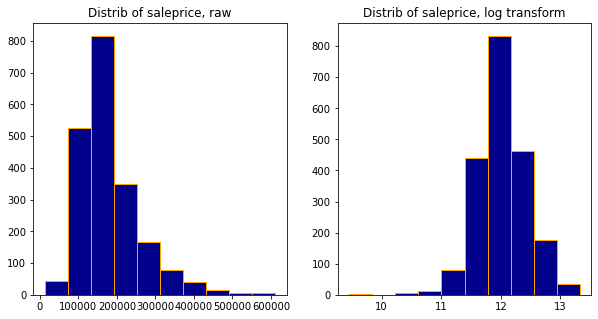

In [43]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_title('Distrib of saleprice, raw')
ax1.hist(training['saleprice'], color = 'darkblue', ec='orange');

ax2 = plt.subplot(1,2,2)
ax2.set_title('Distrib of saleprice, log transform')
ax2.hist(np.log1p(training['saleprice']),color='darkblue', ec='orange');

In [44]:
#log1p method used in source 3 and I used here not realizing it was different than log.
#must use np.expm1 to exponentiate
#didn't bite me in the ass here bc no coefficient interpretation 
#but caused issues in analysis for presentation
y = np.log1p(training['saleprice'])

# RESPLIT TRAIN AND TEST

In [45]:
training_dum = pd.concat([allofit_dum.loc[allofit_dum['is_train']==1],y], axis=1)
testing_clean = allofit_dum.loc[allofit_dum['is_train'] != 1]

In [46]:
# print(training_dum.shape)
# training_dum.head()
# testing_clean.shape
# training_dum.isnull().sum().sort_values(ascending=False)
# testing_clean.isnull().sum().sort_values(ascending=False) #zeros for days

## Correlation
Now that things are clean(er), let's look at correlation of numeric vars. Heatmap is overwhelming because overloaded, but can pick out heaviest hitters for saleprice.

My first approach would be to select the most strongly correlated variables, and pare them down further by trying to eliminate collinearity (ie garage sqft and garage car capacity are collinear, drop one, or combine). Looking ahead it seems like Lasso and Ridge approaches specifically address multicollinearity and parsimony, likely with much better results than I will get by thinking about real estate.

For now, move forward with rudimentary MLR. Then incorporate techniques from the more instructuve kernels and upcoming lecture and see what changes.

In [47]:
# #way too busy
# plt.figure(figsize=(16,12))
# mask=np.zeros_like(allofit_dum.corr())
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(allofit_dum.corr(),cmap='coolwarm', annot=False,mask=mask, vmin=-1, vmax=1);

In [48]:
training_dum.corr()[['saleprice']].sort_values('saleprice', ascending=False)
# 38 vars with corr >.3

,saleprice
saleprice,1.000000
overall_qual,0.816386
gr_liv_area,0.708457
bsmt_qual,0.694069
exter_qual,0.689246
...,...
exterior_1st_PreCast,NaN
exterior_2nd_Other,NaN
exterior_2nd_PreCast,NaN
heating_Floor,NaN


In [49]:
#mod from Gwen's 'my_hist'
def resids_hist(resids, title, x_label, y_label='Frequency', size_var = 18):
    plt.figure(figsize=(6,10));
    sns.displot(x = resids);
    plt.title(title, fontsize = size_var, pad = size_var / 2);
    plt.xlabel(x_label, fontsize = size_var, labelpad = size_var/2)
    plt.xticks(fontsize=size_var/2, rotation=45)
    plt.ylabel(y_label, fontsize = size_var, labelpad = size_var/2)
    plt.yticks(fontsize=size_var/2, rotation=90);

# Model A: Linear Regression, log-transformed y, filter by corr
First go: include all variables with corr >= 0.3
- does not account for collinearity
- definitely high variance

---
Workflow:
- Create features matrix (X), and target vector (y)
- Train, test, split
- DUMMY MODEL
- Instantiate model
- Cross validate
- Fit and Score

In [50]:
#index all features of .3 corr, drop target
corrs_over3 = training_dum.corr()['saleprice'].sort_values(ascending = False).loc[training_dum.corr()['saleprice']>.3].drop('saleprice').index
#corrs_over3   #half_bath, huh?

In [51]:
#TTS for local validation
X = training_dum[corrs_over3]
y = training_dum['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Dummy model A: aka Baseline model: aka Null model
Source for workflow and code: breakout discussion with Gwen

The dummy model has RMSE of about 80,000 (training=81k, testing=78k).  And a NEGATIVE R2 score!  Baseline is straight up Wrong?  I might be exponentiating in the wrong place.  The dummy model provides a look at what a model with no actual predictive capacity looks like.  The y_preds are constant through training and testing.  Baseline_pred equals the mean of y_train.  Below I exponentiate this mean to account for the log transformation of y.  This inverse transform puts us back in interpretable units.  

RMSE score of 81,114 tells us the standard deviation of the unexplained variance is +/- $80,000.  

As of writing this I am #1 on the leaderboard what is going on.

In [52]:
#manual for comprehension
#predict only mean of y_train
## INVERSE TRANSFORM Y_TRAIN HERE
dummy_train_preds = [np.expm1(np.mean(y_train))] * len(y_train)
dummy_test_preds = [np.expm1(np.mean(y_train))] * len(y_test)

In [53]:
#(squared = False) == RMSE
mean_squared_error(np.expm1(y_train), dummy_train_preds, squared=False), mean_squared_error(np.expm1(y_test), dummy_test_preds, squared=False)

(81144.18560290833, 78123.62221931538)

In [54]:
##Now with DummyRegressor tool for future repetition

In [55]:
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)

DummyRegressor()

In [56]:
#rmse with mse & dummy_model.predict
mean_squared_error(np.expm1(y_train), np.expm1(dummy_model.predict(y_train)),squared=False), mean_squared_error(np.expm1(y_test), np.expm1(dummy_model.predict(y_test)), squared=False)

(81144.1856029074, 78123.62221931462)

In [57]:
#by function
def dummy_mod(X_train, x_test, y_train, y_test):
    dummy_model = DummyRegressor()
    dummy_model.fit(X_train, y_train)
    resids = y_test - dummy_model.predict(X_test)
    print(f'r2: train, test = {r2_score(np.expm1(y_train), np.expm1(dummy_model.predict(y_train))), r2_score(np.expm1(y_test), np.expm1(dummy_model.predict(y_test)))}')
    print(f'rmse: baseline train, test = {mean_squared_error(np.expm1(y_train), np.expm1(dummy_model.predict(y_train)),squared=False), mean_squared_error(np.expm1(y_test), np.expm1(dummy_model.predict(y_test)), squared=False)}')   
    return resids_hist(resids, title='Resids Distrib', x_label='Residuals', y_label='Frequency', size_var=18);

r2: train, test = (-0.03482180973470861, -0.023186984939064015)
rmse: baseline train, test = (81144.1856029074, 78123.62221931462)


<Figure size 432x720 with 0 Axes>

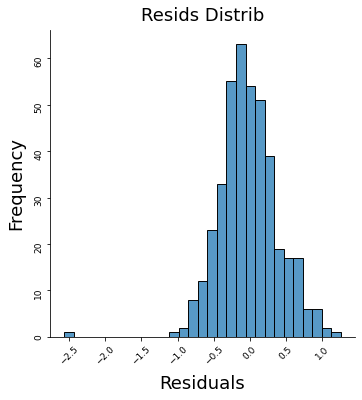

In [58]:
#test func
dummy_mod(X_train, X_test, y_train, y_test)

### Model A: instantiate, cross-val, fit, score

cross val score, mean: 0.887967
RMSE train, test:(22499.86, 22376.71)


<Figure size 432x720 with 0 Axes>

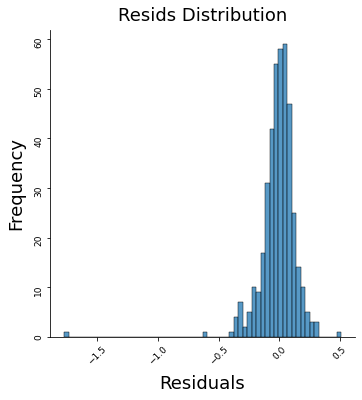

In [59]:
def linreg_fit_score(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred=lr.predict(X_test)
    resids = y_test - y_pred
    print(f'cross val score, mean: {cross_val_score(lr, X_train, y_train, cv=5).mean().round(6)}')
    print(f'RMSE train, test:{mean_squared_error(np.expm1(y_train), np.expm1(lr.predict(X_train)), squared=False).round(2), mean_squared_error(np.expm1(y_test), np.expm1(lr.predict(X_test)), squared=False).round(2)}')    
    return resids_hist(resids,title='Resids Distribution', x_label='Residuals', y_label='Frequency',size_var=18);
        
#evaluating model a: training data only   
linreg_fit_score(X_train, X_test, y_train, y_test)

#### For submission: using Actual Test Set

In [60]:
X_cols = [corrs_over3]
y = training_dum['saleprice']

In [61]:
#for presentation:
lr = LinearRegression()
lr.fit(training_dum[corrs_over3],y)

LinearRegression()

In [62]:
lr.coef_

array([ 5.24007725e-03,  2.31499819e-04,  1.73787117e-03,  1.54803231e-03,
        4.24678419e-03,  7.51137884e-03,  9.87293423e-05,  1.87958885e-05,
        1.94769187e-05,  5.86253015e-04,  1.91203505e-03,  7.61680981e-03,
       -2.39555672e-05,  1.95760322e-02,  6.04051018e-04,  2.64382952e-03,
        4.68228624e-03,  3.96120392e-02,  1.78227117e-05,  8.35833074e-05,
        1.32168295e-02,  7.92965651e-04, -1.05811275e-02,  3.44780566e-03,
        1.08548496e-01, -5.35266926e-03,  1.02973237e-01,  3.45550073e-04,
        6.58458440e-02,  1.11616499e-02, -7.94537144e-02,  2.52041728e-05,
        5.70294832e-05,  1.32960302e-03,  7.08114000e-04,  5.09959474e-02,
        7.00077338e-03])

In [63]:
def linreg_submit(train_df, X_cols, y, test_df, version):
    lr = LinearRegression()
    lr.fit(train_df[X_cols], y)  #no tts splits here, that was just for local validation
    test_preds = np.expm1(lr.predict(test_df[X_cols])) #exponentiate output
    kaggle_submission = {
        'Id' : test_df['id'],
        'SalePrice' : test_preds
    }
    kaggle_submission = pd.DataFrame(kaggle_submission)
    kaggle_submission.to_csv('./kaggle_submissions_all/'+version+'.csv',index=False)
    return kaggle_submission.tail(10)


In [64]:
#train_df = training_dum, test_df = testing_clean
#linreg_submit(train_df = training_dum, X_cols = corrs_over3, y= training_dum['saleprice'], test_df = testing_clean, version = 'LRv1')
# SUBMITTED 4/13/21. Kaggle Score 24426.01049

# Model B: same as A, + log-transform all numerical vars with skew>.5
---
### Just like for [saleprice] -- np.log1p
---
##### Following steps from sources 3 and 4.

In [65]:
allofit_basic_clean.head() #combo training + test data, but no saleprice

,id,pid,ms_subclass,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,...,sale_type_COD,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
0,109,533352170,60,68.0,13517,9,16,9,36,64,...,0,0,0,0,0,0,0,0,0,1
1,544,531379050,60,43.0,11492,9,16,9,49,25,...,0,0,0,0,0,0,0,0,0,1
2,153,535304180,20,68.0,7922,16,16,9,25,49,...,0,0,0,0,0,0,0,0,0,1
3,318,916386060,60,73.0,9802,16,16,9,25,25,...,0,0,0,0,0,0,0,0,0,1
4,255,906425045,50,82.0,14235,9,16,9,36,64,...,0,0,0,0,0,0,0,0,0,1


In [66]:
#isolate numerical vs categorical vars
cats = allofit_basic_clean.select_dtypes(include= ['object']).columns
nums = allofit_basic_clean.select_dtypes(exclude= ['object']).columns
all_cats = allofit_basic_clean[cats]
all_nums = allofit_basic_clean[nums]

In [67]:
#find skewed numeric features.  Code from source 3, and 4
#"general rule of thumb, abv(skew)>.5 is 'moderately skewed'" - source 3
idskew = all_nums.loc[all_nums['is_train']==1].apply(lambda x: skew(x))  #on training data only!
idskew = idskew[abs(idskew)>0.5] #filter to threshold (.5)
idskew_cols = idskew.index  #col names of skewed training vars, now reincorporate testing data

In [68]:
all_nums[idskew_cols] = np.log1p(all_nums[idskew_cols])

In [69]:
#combine nums with categoricals, then split to test / train again
interim = pd.concat([all_nums, all_cats], axis=1)
y = training_dum['saleprice']
training_logged = pd.concat([interim.loc[interim['is_train']==1],y], axis=1)
testing_logged = interim.loc[interim['is_train'] != 1]

##### Rerun correlation with new data; tts X and y

In [70]:
#training_logged.corr()[['saleprice']].sort_values('saleprice', ascending=False).head()
#pretty similar to untransformed list

In [71]:
corrs_over3_log = training_logged.corr()['saleprice'].sort_values(ascending = False).loc[training_logged.corr()['saleprice']>.3].drop('saleprice').index

In [72]:
#TTS for local validation
X = training_logged[corrs_over3]
y = training_logged['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

cross val score, mean: 0.891107
RMSE train, test:(24253.72, 23421.55)


<Figure size 432x720 with 0 Axes>

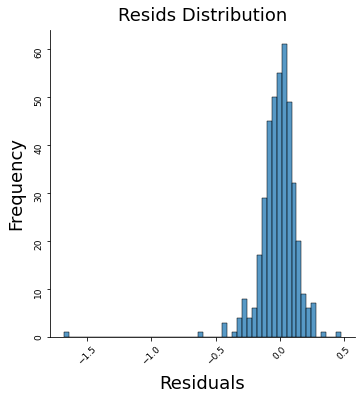

In [73]:
#evaluate model b, training data only
linreg_fit_score(X_train, X_test, y_train, y_test)  #better RMSE test than A, worse train...

# Model C: A + log-transform ONLY continuous vars with skew>.5.  Do not transform discrete numeric vars.

##### Submit - superior to A and B

In [74]:
#discretios = discrete numeric vars defined above in your stretching of the scale:
#start with same process as model B
cats = allofit_basic_clean.select_dtypes(include= ['object']).columns
nums = allofit_basic_clean.select_dtypes(exclude= ['object']).columns
all_cats = allofit_basic_clean[cats]
all_nums = allofit_basic_clean[nums]

In [75]:
idskew = all_nums.loc[all_nums['is_train']==1].apply(lambda x: skew(x))  #on training data only!
idskew = idskew[abs(idskew)>0.5]

In [76]:
#not all discretios are in list of skewed nums
#which ones are?
def drop_discretios(skewlist, discretes):
    fixed=[]
    for i in discretes:
        if i in skewlist:
            fixed.append(i)
    return fixed

In [77]:
tofilter = drop_discretios(idskew, discretios)

In [78]:
#remove discrete vars from list of skew-to-be-transformed
idskew.drop(tofilter, inplace=True)
idskew_cols = idskew.index  #col names of skewed training vars, now reincorporate testing data

In [79]:
all_nums[idskew_cols] = np.log1p(all_nums[idskew_cols])

In [80]:
#combine nums with categoricals, then split to test / train again
interim = pd.concat([all_nums, all_cats], axis=1)
y = training_dum['saleprice']
training_contlog = pd.concat([interim.loc[interim['is_train']==1],y], axis=1)
testing_contlog = interim.loc[interim['is_train'] != 1]

In [81]:
#export for future reference (ie presentation)
#have to do this wonky order because of index issues
step1 = pd.concat([interim.loc[interim['is_train']==1], training['saleprice']], axis = 1)
step2 = pd.concat([step1, interim.loc[interim['is_train']==0]],axis=0)
step2.to_csv('./datasets/datasets_ignore/merged_logged_dummied.csv')

In [82]:
step1.tail()

,id,pid,ms_subclass,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,...,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD,saleprice
2046,1587,921126030,3.044522,4.382027,9.345745,9,16,9,64,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.693147,298751
2047,785,905377130,3.433987,4.234107,9.420844,9,16,9,16,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.693147,82500
2048,916,909253010,3.931826,4.060443,8.930494,16,16,9,36,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.693147,177000
2049,639,535179160,3.044522,4.394449,9.249657,16,16,9,16,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.693147,144000
2050,10,527162130,4.110874,4.110874,8.922792,16,16,9,49,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.693147,189000


##### Rerun corr, tts

In [83]:
training_contlog.corr()[['saleprice']].sort_values('saleprice', ascending=False).head()
#still pretty similar to untransformed list
corrs_over3_contlog = training_contlog.corr()['saleprice'].sort_values(ascending = False).loc[training_contlog.corr()['saleprice']>.3].drop('saleprice').index

In [84]:
#TTS for local validation
X = training_contlog[corrs_over3_contlog]
y = training_contlog['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

cross val score, mean: 0.893182
RMSE train, test:(22744.75, 21349.45)


<Figure size 432x720 with 0 Axes>

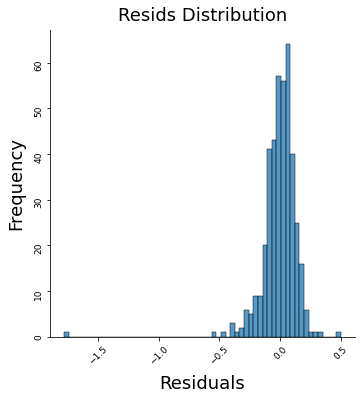

In [85]:
linreg_fit_score(X_train, X_test, y_train, y_test)  #RMSE train same as A, test better...

In [86]:
#### For submission: using Actual Test Set
X_cols = [corrs_over3_contlog]
y = training_dum['saleprice']

In [87]:
#linreg_submit(train_df = training_contlog, X_cols = corrs_over3_contlog, y= training_dum['saleprice'], test_df = testing_contlog, version = 'LRv2')
# SUBMITTED 4/13/21. Kaggle Score 23339.00799

### Model D: Model C but only top 10 most correlated features
Will parsimony improve things?  
Nope, worse. 

In [88]:
training_contlog.corr()[['saleprice']].sort_values('saleprice', ascending=False).head(11)
corrs10_contlog = training_contlog.corr()['saleprice'].sort_values(ascending=False)[:11].drop('saleprice').index

cross val score, mean: 0.853537
RMSE train, test:(26630.82, 26321.69)


<Figure size 432x720 with 0 Axes>

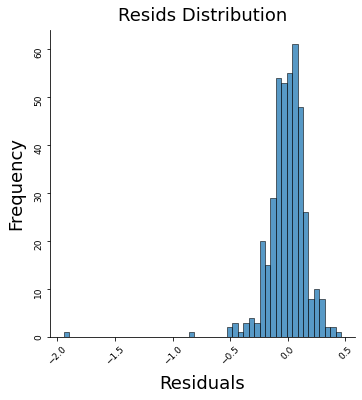

In [89]:
X = training_contlog[corrs10_contlog]
y = training_contlog['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
linreg_fit_score(X_train, X_test, y_train, y_test)

# Ridge
Nothing fancy - no polynomials or feature combining/creation to address collinearity and interaction.  Just the above, fit into ridge regularization method working through steps from source 3 and class.

In [90]:
#exponentiate within MSE call to undo log transform of y
def model_rmse(model, X_train, X_test, y_train, y_test):
    train_rmse = mean_squared_error(np.expm1(y_train), np.expm1(model.predict(X_train)), squared=False).round(2)
    test_rmse = mean_squared_error(np.expm1(y_test), np.expm1(model.predict(X_test)), squared=False).round(2)
    print(f'train RMSE = {train_rmse}')
    print(f'test RMSE = {test_rmse}')

In [91]:
# #from superior of above models: Model C
# X = training_contlog[corrs_over3_contlog]
# y = training_contlog['saleprice']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

Ran Ridge regularization first using features from the above non-regularized linear models.  These yielded RMSE's Very close to the most succesful lr model (LR model C outperformed the Lasso submission on Kaggle).  Below I try without limiting features to the highly correlated ones I had filtered out earlier.  Maybe letting Ridge/Lasso do their thing on all the features, and reducing coefficients as it deems fit, will improve upon RMSE.

##### There it is.  That was much more impactful than any iterations so far.  (*RMSE from 23k --> 18.2k.). 
##### (*EDIT: Kaggle score actually 21k. Sigh).

In [92]:
X = training_contlog[training_contlog.columns.drop('saleprice')]
y = training_contlog['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [93]:
r_alphas = np.logspace(0,5,100)
ridge = RidgeCV(alphas=r_alphas)
ridge.fit(Z_train, y_train)
alpha1=ridge.alpha_
alpha1

335.1602650938841

In [94]:
#try again for more precision with alphas centered around the above alpha output
# ^^ source 3
ridge = RidgeCV(alphas = np.logspace(2,3,100), cv=10)
ridge.fit(Z_train, y_train)
alpha2 = ridge.alpha_
alpha2

291.50530628251755

In [ ]:
#ENHANCE
ridge = RidgeCV(alphas = np.linspace(100,400, 1000), cv=5)
ridge.fit(Z_train, y_train)
ridge.alpha_

In [ ]:
model_rmse(ridge, Z_train, Z_test, y_train, y_test) #dang, kaggle score 21.3k

In [ ]:
#visualization from source 3
y_train_rdg = ridge.predict(Z_train)
resids_train = y_train_rdg - y_train
y_test_rdg = ridge.predict(Z_test)
resids_test = y_test_rdg - y_test
plt.scatter(y_train_rdg, resids_train, color='blue', label='training split')
plt.scatter(y_test_rdg, resids_test, color='orange', label='testing split')
plt.title('Residuals of linreg with ridge regularization')
plt.xlabel('predicted values')
plt.ylabel('residuals')
plt.legend(loc='upper right')

In [ ]:
#important coefficients - also source 3.  Would not have thought of barh without seeing his.
coefs = pd.Series(ridge.coef_, index=X_train.columns)
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])
plt.figure(figsize=(8,6))
imp_coefs.plot(kind='barh')
plt.yticks(ticks = list(range(0,20,1)), labels=[convert_snake_case(i) for i in imp_coefs.index])
plt.title("Coefficients in Ridge Model", size=16);

#### For Submission:

In [ ]:
X = training_contlog[training_contlog.columns.drop('saleprice')]  #training
y = training_contlog['saleprice']
test_real = testing_contlog
ss = StandardScaler()
Z = ss.fit_transform(X)
Z_test = ss.transform(test_real[test_real.columns])

In [ ]:
#three cycles of np.logspace/linspace to hone in on alpha 285
ridge = RidgeCV(alphas = np.linspace(200,400,100), cv=10)
ridge.fit(Z, y)
ridge.alpha_

In [ ]:
def regularized_submit(model, X, y, test_df, version):
    ss = StandardScaler()
    Z = ss.fit_transform(X)
    Z_test = ss.transform(test_df[test_df.columns])
    test_preds = np.expm1(model.predict(Z_test))
    kaggle_submission = {
    'Id' : test_df['id'],
    'SalePrice' : test_preds
    }
    kaggle_submission = pd.DataFrame(kaggle_submission)
    kaggle_submission.to_csv('./kaggle_submissions_all/'+version+'.csv',index=False)
    return kaggle_submission.tail(5)

In [ ]:
#regularized_submit(ridge, X, y, testing_contlog, 'Ridge1')
# submitted 4/14/21 Kaggle Score 23.1k -- not in line with RMSE 18.2k in tts

### Ridge 2:
The only difference in this model is the scoring parameter has been set to RMSE.  Does it make a difference?  Yes, alpha is different on first round (284->263).  Proceed.

In [ ]:
X = training_contlog[training_contlog.columns.drop('saleprice')]  #training
y = training_contlog['saleprice']
test_real = testing_contlog
ss = StandardScaler()
Z = ss.fit_transform(X)
Z_test = ss.transform(test_real[test_real.columns])

In [ ]:
#several cycles changing np.logspace/linspace range
ridge = RidgeCV(alphas = np.linspace(200,300,100), scoring='neg_mean_squared_error',cv=10)
ridge.fit(Z, y)
ridge.alpha_

In [ ]:
#regularized_submit(ridge, X, y, testing_contlog, 'Ridge2')
#kaggle score 21225.32930 -> outperformed Ridge1, Lasso still superior

# LASSO
The Ridge regularization did much better when given the whole dataframe than when I gave it just the correlation-filtered features used in un-regularized linreg.  However, that was in local RMSE, not Kaggle, so I might be duffing it somewhere.  Regardless, starting with X = all features and adjusting from there if time; also, there's no time.

* Kaggle RMSE higher for Lasso and Ridge models by significant amount (or at least a frustrating amount).  You know from R2 scores that model is overfit, so pare it down in next version.

In [ ]:
#kaggle_submission.to_csv('./kaggle_submissions_all/Lasso_v1.csv',index=False)
#submitted 4/13/21  Kaggle score = 23507.89650   #not better than lr!
#fit with wrong scaling and expm1 in v1.

In [ ]:
#X cols from superior of above models: Model C
X = training_contlog[training_contlog.columns.drop('saleprice')]
y = training_contlog['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [ ]:
ss = StandardScaler()   
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [ ]:
#refine lasso_alphas through several iterations
lasso_alphas = np.logspace(-3,-.5,100)
lasso = LassoCV(alphas=lasso_alphas, cv=5) #cv over list of lasso alphas
lasso.fit(Z_train, y_train)
lasso.alpha_

In [ ]:
print(f'alpha = {lasso.alpha_}') #optimal alpha (aka lambda)
print(f'trian, test R2:{lasso.score(Z_train, y_train), lasso.score(Z_test, y_test)}')  #R2 for training & test

In [ ]:
#rmse with features of Model C was 22k-ish.  Vast improvement by plugging in all features.
model_rmse(lasso, Z_train, Z_test, y_train, y_test)

In [ ]:
#regularized_submit(lasso, X, y, testing_contlog, 'Lasso_v2')
# Submitted 4/14/21. Kaggle score = 21052.45544

In [ ]:
#plotting bc foresee using in presentation: ala source 3
coefs_lasso = pd.Series(lasso.coef_, index=X_train.columns)
imp_coefs = pd.concat([coefs_lasso.sort_values().head(10), coefs_lasso.sort_values().tail(10)])
plt.figure(figsize=(8,6))
imp_coefs.plot(kind='barh')
plt.yticks(ticks = list(range(0,20,1)), labels=[convert_snake_case(i) for i in imp_coefs.index])
plt.title("Coefficients in Lasso Model", size=16);

In [ ]:
# #guiding presentation research:
# lasso_coefs = coefs_lasso.sort_values(ascending=False)
# lasso_coefs.to_csv('./datasets/datasets_ignore/lasso_coefs.csv')

### Lasso v3:
In this step, I refine the above attempt at Lasso by changing gears entirely to work on a presentation for a non-Kaggle-related problem statement that I have definitely have under control.

# Conclusions
The Lasso and Ridge Regularization models work best when fed all features and allowed to cull (reduce coefficients) at their discretion.  My dummy model performed absolutely abysmally by r2 and RMSE metrics, making it not hard to improve upon.

There are many other approaches to cleaning, binning, and organizing that I am curious to try: I numified many categorical variables, but perhaps leaving them as objects with new broader groupings/definitions could have parsed out some more interpretable relationships.  For this portion of the project, interpretability is not a priority so I just kept blindly tinkering until RMSE scores crept down.  Honestly, my first go with regular linreg was one of my best scores, proof enough that it was due to luck, not mastery.

I would like to feel more comfortable with this process instead of totally feeling around in the dark.  Kaggle kernels were key for seeing how to approach this kind of data mess.  Now it is time to try more independently instead of frankensteining 5 unrelated sources together.